In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Testes de Modelos de Clusterização

In [2]:
caminho = r"C:\Users\anabe\Documents\FIAP\Ano 2\0. Challenge\codigos_challenge_2\df_bin.csv"
df = pd.read_csv(caminho)


In [3]:
df.sample(10)

,CD_CLIENTE,DS_LIN_REC_CDU,DS_LIN_REC_CLOUD,DS_LIN_REC_CONSULTORIA & SERVIÇOS,DS_LIN_REC_OUTROS,DS_LIN_REC_SAAS,DS_LIN_REC_SMS,DS_SEGMENTO_AGROINDUSTRIA,DS_SEGMENTO_CONSTRUCAO E PROJETOS,DS_SEGMENTO_DISTRIBUICAO,...,FAIXA_VL_CONTRATO_FIXA_até R$5k,FAIXA_VL_CONTRATO_FIXA_R$5k–20k,FAIXA_VL_CONTRATO_FIXA_R$20k–100k,FAIXA_VL_CONTRATO_FIXA_R$100k–500k,FAIXA_VL_CONTRATO_FIXA_R$500k–1M,FAIXA_VL_CONTRATO_FIXA_>R$1M,TEMPO_CLIENTE_FAIXA_Recente (0-3),TEMPO_CLIENTE_FAIXA_Estabelecido (3-10),TEMPO_CLIENTE_FAIXA_Madura (>10),CLIENTE_ATIVO
3332,TEZIL9,1,1,1,1,1,1,0,0,0,...,0,0,0,1,0,0,0,0,1,1
5120,TFDN23,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
2758,TDCGPY,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
5503,TFEBOM,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1684,TB3207,1,0,0,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,1,1
4965,TFDFUZ,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
4783,TFDANF,1,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,1
3730,TFBMJ3,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
381,T13852,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,1
3959,TFC340,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1


# GMM

Dimensões originais: 37 → após PCA: 21 (80% var.)

Top por métrica:
• Silhouette  (↑): K=21 | 0.1911
• Davies-Bouldin (↓): K=21 | 1.5053
• Calinski-Harabasz (↑): K=18 | 396.14
• AIC (↓): K=22 | -371830.5
• BIC (↓): K=22 | -334891.1

Top 5 por Silhouette:
 K  silhouette  davies_bouldin  calinski_harabasz            AIC            BIC
21    0.191144        1.505255         378.395097 -362577.412560 -327317.330602
18    0.187379        1.512828         396.137837 -306372.671035 -276150.691901
20    0.181605        1.514916         368.159955 -338623.632493 -305042.918143
16    0.177316        1.755887         350.815079 -284132.310801 -257269.066884
22    0.174286        1.523147         390.030275 -371830.513479 -334891.063912


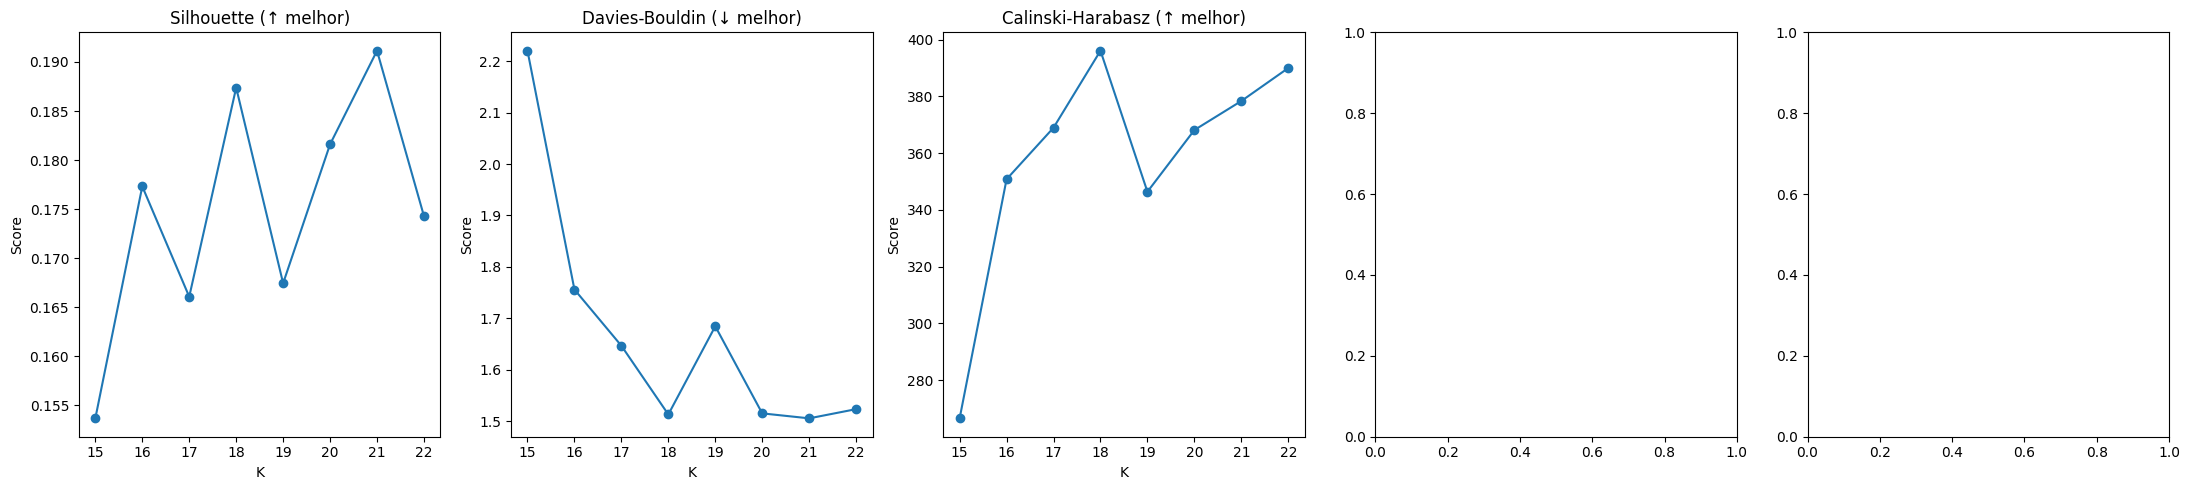

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------- 0) Preparos opcionais ----------
# Limpa espaços/caracteres invisíveis em nomes de colunas
df.columns = df.columns.str.strip().str.replace("\xa0", " ", regex=True)

# ---------- 1) Preparar dados (sem a coluna de ID, se existir) ----------
id_col = "CD_CLIENTE"
df_cluster = df.drop(columns=[id_col]) if id_col in df.columns else df.copy()
X = df_cluster.values

# Padronizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------- 2) PCA ----------
# n_components como fração (= 0.8 => reter 80% da variância)
pca = PCA(n_components=0.8, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"Dimensões originais: {X_scaled.shape[1]} → após PCA: {X_pca.shape[1]} (80% var.)")

# ---------- 3) GMM em vários K + métricas ----------
k_range = range(15, 23)  # 10..22
rows = []

for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    labels = gmm.fit_predict(X_pca)

    sil = silhouette_score(X_pca, labels)
    db  = davies_bouldin_score(X_pca, labels)
    ch  = calinski_harabasz_score(X_pca, labels)

    # AIC/BIC do GMM (quanto menor, melhor)
    aic = gmm.aic(X_pca)
    bic = gmm.bic(X_pca)

    rows.append({"K": k, "silhouette": sil, "davies_bouldin": db,
                 "calinski_harabasz": ch, "AIC": aic, "BIC": bic})

results = pd.DataFrame(rows)

# ---------- 4) Mostrar resultados numéricos ----------
# Melhores K por métrica
best_sil = results.loc[results["silhouette"].idxmax()]
best_db  = results.loc[results["davies_bouldin"].idxmin()]
best_ch  = results.loc[results["calinski_harabasz"].idxmax()]
best_aic = results.loc[results["AIC"].idxmin()]
best_bic = results.loc[results["BIC"].idxmin()]

print("\nTop por métrica:")
print(f"• Silhouette  (↑): K={int(best_sil.K)} | {best_sil.silhouette:.4f}")
print(f"• Davies-Bouldin (↓): K={int(best_db.K)} | {best_db.davies_bouldin:.4f}")
print(f"• Calinski-Harabasz (↑): K={int(best_ch.K)} | {best_ch.calinski_harabasz:.2f}")
print(f"• AIC (↓): K={int(best_aic.K)} | {best_aic.AIC:.1f}")
print(f"• BIC (↓): K={int(best_bic.K)} | {best_bic.BIC:.1f}")

print("\nTop 5 por Silhouette:")
print(results.sort_values("silhouette", ascending=False).head(5).to_string(index=False))

# (Opcional) Exportar CSV
# results.to_csv("gmm_metrics_pca80.csv", index=False)

# ---------- 5) Plots ----------
fig, axes = plt.subplots(1, 5, figsize=(22,5))

axes[0].plot(results["K"], results["silhouette"], marker="o")
axes[0].set_title("Silhouette (↑ melhor)")
axes[0].set_xlabel("K"); axes[0].set_ylabel("Score")

axes[1].plot(results["K"], results["davies_bouldin"], marker="o")
axes[1].set_title("Davies-Bouldin (↓ melhor)")
axes[1].set_xlabel("K"); axes[1].set_ylabel("Score")

axes[2].plot(results["K"], results["calinski_harabasz"], marker="o")
axes[2].set_title("Calinski-Harabasz (↑ melhor)")
axes[2].set_xlabel("K"); axes[2].set_ylabel("Score")

plt.tight_layout()
plt.show()



# K-Means

Dimensões originais: 37 → após PCA: 21

Top por métrica - KMeans
K                     22.000000
silhouette             0.219678
davies_bouldin         1.237629
calinski_harabasz    470.427331
Name: 7, dtype: float64
K                     20.000000
silhouette             0.209924
davies_bouldin         1.198773
calinski_harabasz    475.405777
Name: 5, dtype: float64
K                     21.000000
silhouette             0.213476
davies_bouldin         1.221851
calinski_harabasz    476.204277
Name: 6, dtype: float64


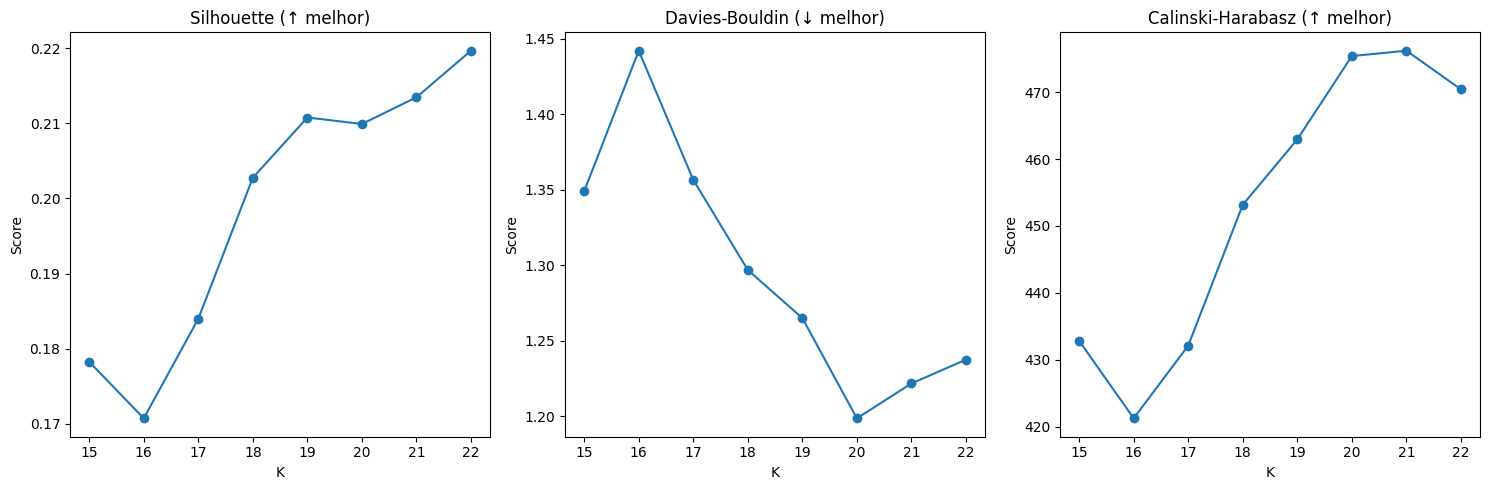

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Padronização ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 2. PCA (80% variância) ---
pca = PCA(n_components=0.8, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Dimensões originais: {X_scaled.shape[1]} → após PCA: {X_pca.shape[1]}")

# --- 3. Testar K-Means em vários Ks ---
results_kmeans = []
k_range = range(15, 23)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(X_pca)
    
    sil = silhouette_score(X_pca, labels)
    db  = davies_bouldin_score(X_pca, labels)
    ch  = calinski_harabasz_score(X_pca, labels)
    
    results_kmeans.append({"K": k, "silhouette": sil,
                           "davies_bouldin": db,
                           "calinski_harabasz": ch})

df_kmeans = pd.DataFrame(results_kmeans)

# --- 4. Resultados numéricos ---
print("\nTop por métrica - KMeans")
print(df_kmeans.loc[df_kmeans["silhouette"].idxmax()])
print(df_kmeans.loc[df_kmeans["davies_bouldin"].idxmin()])
print(df_kmeans.loc[df_kmeans["calinski_harabasz"].idxmax()])

# --- 5. Plots ---
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(df_kmeans["K"], df_kmeans["silhouette"], marker="o")
plt.title("Silhouette (↑ melhor)")
plt.xlabel("K"); plt.ylabel("Score")

plt.subplot(1,3,2)
plt.plot(df_kmeans["K"], df_kmeans["davies_bouldin"], marker="o")
plt.title("Davies-Bouldin (↓ melhor)")
plt.xlabel("K"); plt.ylabel("Score")

plt.subplot(1,3,3)
plt.plot(df_kmeans["K"], df_kmeans["calinski_harabasz"], marker="o")
plt.title("Calinski-Harabasz (↑ melhor)")
plt.xlabel("K"); plt.ylabel("Score")

plt.tight_layout()
plt.show()



# HDBSCAN

In [8]:
pip install hdbscan


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: C:\Users\anabe\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Dimensões originais: 37 → após PCA: 21 (80% var.)

Top por métrica - HDBSCAN
min_cluster_size    15.000000
min_samples         10.000000
epsilon              0.010000
num_clusters        98.000000
outlier_rate         0.346392
silhouette           0.225662
Name: 0, dtype: float64
min_cluster_size    15.000000
min_samples         10.000000
epsilon              0.010000
num_clusters        98.000000
outlier_rate         0.346392
davies_bouldin       1.376438
Name: 0, dtype: float64
min_cluster_size      45.000000
min_samples           10.000000
epsilon                0.010000
num_clusters          36.000000
outlier_rate           0.299947
calinski_harabasz    149.764421
Name: 10, dtype: float64

Top 5 por Silhouette - HDBSCAN
 min_cluster_size  min_samples  epsilon  num_clusters  outlier_rate  silhouette  davies_bouldin  calinski_harabasz
               15           10     0.01            98      0.346392    0.225662        1.376438          62.334760
               18           10     0

Text(0, 0.5, 'Score')

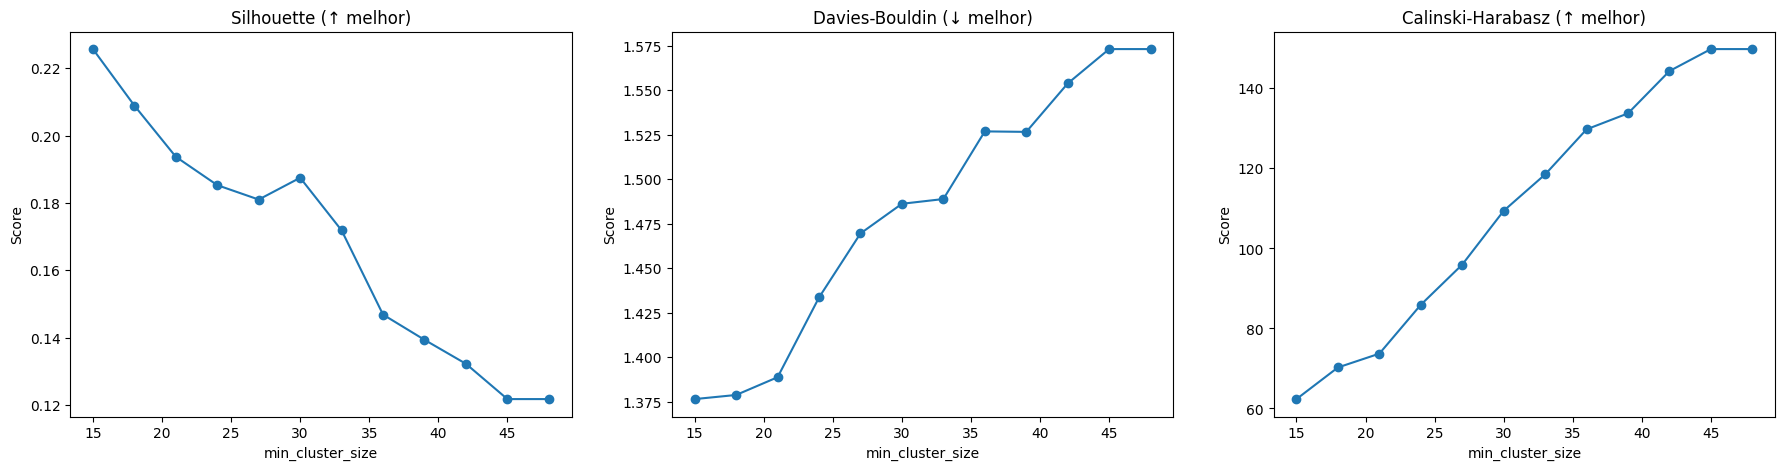

In [9]:
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1) Preparação dos dados
# =========================
# Elimine ID se existir
id_col = "CD_CLIENTE"
df_cluster = df.drop(columns=[id_col]) if id_col in df.columns else df.copy()
X = df_cluster.values

# Padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA (ajuste para 0.8 ou 0.9 conforme desejar)
pca_var = 0.8  # <-- troque para 0.9 se quiser
pca = PCA(n_components=pca_var, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Dimensões originais: {X_scaled.shape[1]} → após PCA: {X_pca.shape[1]} ({int(pca_var*100)}% var.)")

# =========================================
# 2) Varredura de parâmetros do HDBSCAN
# =========================================
# Usaremos min_cluster_size como “eixo” comparável ao K
mcs_values = list(range(15, 51, 3))  # ajuste livre (ex.: 15..50, passo 3)
min_samples = 10                     # mantenha fixo ou torne proporcional (ex.: = mcs//3)
epsilon = 0.01

rows = []
for mcs in mcs_values:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=mcs,
                                min_samples=min_samples,
                                metric='euclidean',
                                cluster_selection_epsilon=epsilon)
    labels = clusterer.fit_predict(X_pca)

    # n_clusters (desconsiderando -1)
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

    # % outliers
    outlier_rate = np.mean(labels == -1) if len(labels) > 0 else np.nan

    # Métricas (só fazem sentido se houver >1 cluster)
    if n_clusters > 1:
        sil = silhouette_score(X_pca, labels)
        db  = davies_bouldin_score(X_pca, labels)
        ch  = calinski_harabasz_score(X_pca, labels)
    else:
        sil, db, ch = np.nan, np.nan, np.nan

    rows.append({
        "min_cluster_size": mcs,
        "min_samples": min_samples,
        "epsilon": epsilon,
        "num_clusters": n_clusters,
        "outlier_rate": outlier_rate,
        "silhouette": sil,
        "davies_bouldin": db,
        "calinski_harabasz": ch
    })

df_hdbscan = pd.DataFrame(rows)

# ===================================================
# 3) Resultados numéricos (igual aos outros modelos)
# ===================================================
valid = df_hdbscan[df_hdbscan["num_clusters"] > 1].copy()

print("\nTop por métrica - HDBSCAN")
if not valid.empty:
    best_sil = valid.loc[valid["silhouette"].idxmax()]
    best_db  = valid.loc[valid["davies_bouldin"].idxmin()]
    best_ch  = valid.loc[valid["calinski_harabasz"].idxmax()]

    print(best_sil[["min_cluster_size","min_samples","epsilon","num_clusters","outlier_rate","silhouette"]])
    print(best_db[["min_cluster_size","min_samples","epsilon","num_clusters","outlier_rate","davies_bouldin"]])
    print(best_ch[["min_cluster_size","min_samples","epsilon","num_clusters","outlier_rate","calinski_harabasz"]])

    print("\nTop 5 por Silhouette - HDBSCAN")
    print(valid.sort_values("silhouette", ascending=False).head(5).to_string(index=False))
else:
    print("Sem configurações com mais de 1 cluster — ajuste min_cluster_size/min_samples.")

# ======================================
# 4) Plots (mesma lógica dos seus)
# ======================================
fig, axes = plt.subplots(1, 3, figsize=(22,5))

axes[0].plot(df_hdbscan["min_cluster_size"], df_hdbscan["silhouette"], marker="o")
axes[0].set_title("Silhouette (↑ melhor)")
axes[0].set_xlabel("min_cluster_size"); axes[0].set_ylabel("Score")

axes[1].plot(df_hdbscan["min_cluster_size"], df_hdbscan["davies_bouldin"], marker="o")
axes[1].set_title("Davies-Bouldin (↓ melhor)")
axes[1].set_xlabel("min_cluster_size"); axes[1].set_ylabel("Score")

axes[2].plot(df_hdbscan["min_cluster_size"], df_hdbscan["calinski_harabasz"], marker="o")
axes[2].set_title("Calinski-Harabasz (↑ melhor)")
axes[2].set_xlabel("min_cluster_size"); axes[2].set_ylabel("Score")



# Resultado Comparativo

| Modelo      | PCA | K / #Clusters    | Silhouette ↑ | Davies-Bouldin ↓ | Calinski-Harabasz ↑         |
| ----------- | --- | ---------------- | ------------ | ---------------- | --------------------------- |
| **GMM**     | 90% | 22               | 0.1900       | 1.5723           | 386.5                       |
| **GMM**     | 80% | 21 (Silh/DB)     | 0.1911       | 1.5053           | 378.4 (K=21) / 396.1 (K=18) |
| **K-Means** | 90% | 22               | 0.2066       | 1.3093           | 420.5                       |
| **K-Means** | 80% | 22               | **0.2197**✅   | **1.2376**✅       | **470.4**✅                   |
| **HDBSCAN** | 90% | \~53 (+outliers) | 0.1957       | 1.5163           | 120.1                       |
| **HDBSCAN** | 80% | \~55 (+outliers) | 0.2038       | 1.4057           | 119.6                       |


# Modelo Escolhido: K-Means
### Análises dos Clusters

In [10]:
df["cluster"] = kmeans.labels_
df["cluster"].value_counts()


cluster
13    694
2     445
15    433
12    431
3     409
1     346
14    328
16    328
7     326
4     325
20    303
9     275
0     263
21    245
17    147
11    105
5      92
10     74
19     63
8       5
6       2
18      2
Name: count, dtype: int64

In [17]:
best_k = 22  # substitua pelo valor escolhido

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels_final = kmeans_final.fit_predict(X_pca)

# --- 6. De-para cliente x cluster ---
df_de_para = pd.DataFrame({
    "CD_CLIENTE": df["CD_CLIENTE"],   # mantém IDs originais
    "Cluster": labels_final
})

# --- 7. Exportar ---
output_path = r"C:\Users\anabe\Documents\FIAP\Ano 2\0. Challenge\Challenge_TOTVS_2025_MassaDados_v1\Clusters Results\df_depara_clientid_clusters.csv"
df_de_para.to_csv(output_path, index=False, encoding="utf-8-sig")


,CD_CLIENTE,Cluster
0,99069,21
1,99958,19
2,99999,6
3,T00018,1
4,T00053,5
...,...,...
5636,TFEET1,4
5637,TFEET3,13
5638,TFEET5,13
5639,TFEETF,20


In [15]:
import pandas as pd

# --- 1. Preparar base (clusters grandes apenas) ---
counts = df["cluster"].value_counts()
limite = 30
clusters_validos = counts[counts >= limite].index
df_filtrado = df[df["cluster"].isin(clusters_validos)].copy()

# --- 2. Prevalência global (média de cada variável binária) ---
global_prev = df_filtrado.drop(columns=["CD_CLIENTE", "cluster"], errors="ignore").mean()

# --- 3. Prevalência por cluster ---
cluster_prev = df_filtrado.groupby("cluster").mean(numeric_only=True)

# --- 4. Calcular lift e delta ---
lift = cluster_prev.divide(global_prev).round(2)     # cluster % ÷ global %
delta = (cluster_prev - global_prev).round(3)        # cluster % - global %

# --- 5. Montar resumo analítico ---
resumos = {}
for cl in cluster_prev.index:
    df_cluster = pd.DataFrame({
        "prevalencia": cluster_prev.loc[cl],
        "prev_global": global_prev,
        "lift": lift.loc[cl],
        "delta_abs": delta.loc[cl]
    }).sort_values("lift", ascending=False)
    
    resumos[cl] = df_cluster.head(10)  # top 10 variáveis mais relevantes
    print(f"\n🔎 Cluster {cl} — {len(df_filtrado[df_filtrado['cluster']==cl])} clientes")
    print(resumos[cl].to_string())



🔎 Cluster 0 — 263 clientes
                                    prevalencia  prev_global  lift  delta_abs
FAT_FAIXA_AGRUPADA_ACIMA 150M          0.817490     0.089666  9.12      0.728
FAIXA_VL_CONTRATO_FIXA_R$100k–500k     0.882129     0.150746  5.85      0.731
DS_SEGMENTO_MANUFATURA                 0.593156     0.214311  2.77      0.379
DS_LIN_REC_OUTROS                      0.304183     0.115945  2.62      0.188
TEMPO_CLIENTE_FAIXA_Madura (>10)       0.851711     0.409091  2.08      0.443
DS_LIN_REC_SMS                         0.680608     0.386009  1.76      0.295
DS_LIN_REC_CDU                         0.844106     0.544034  1.55      0.300
DS_SEGMENTO_SERVICOS                   0.220532     0.197798  1.11      0.023
DS_LIN_REC_CLOUD                       0.178707     0.175071  1.02      0.004
CLIENTE_ATIVO                          0.946768     0.946733  1.00      0.000

🔎 Cluster 1 — 346 clientes
                                         prevalencia  prev_global  lift  delta_abs
DS_

In [ ]:
from sklearn.metrics import silhouette_samples
import pandas as pd
import numpy as np

# --- 1. Filtrar clusters pequenos ---
counts = df["cluster"].value_counts()
limite = 30
clusters_validos = counts[counts >= limite].index
df_filtrado = df[df["cluster"].isin(clusters_validos)].copy()

# --- 2. Prevalência global ---
global_prev = df_filtrado.drop(columns=["CD_CLIENTE", "cluster"], errors="ignore").mean()

# --- 3. Prevalência por cluster ---
cluster_prev = df_filtrado.groupby("cluster").mean(numeric_only=True)

# --- 4. Lift e Delta ---
_eps = 1e-9
lift = cluster_prev.divide(global_prev.replace(0, _eps)).round(3)
delta = (cluster_prev - global_prev).round(4)

# --- 5. Silhouette por amostra e média por cluster ---
sample_sil = silhouette_samples(
    df_filtrado.drop(columns=["CD_CLIENTE", "cluster"], errors="ignore"),
    df_filtrado["cluster"]
)
df_filtrado["silhouette_sample"] = sample_sil
cluster_silhouette = df_filtrado.groupby("cluster")["silhouette_sample"].mean()

# --- 6. Montar DataFrame longo enriquecido ---
rows = []
for cl in cluster_prev.index:
    size = len(df_filtrado[df_filtrado["cluster"] == cl])
    perc_total = size / len(df_filtrado)
    sil_mean = cluster_silhouette.loc[cl]
    
    df_cluster = pd.DataFrame({
        "cluster": cl,
        "cluster_size": size,
        "perc_total": perc_total,
        "cluster_silhouette": sil_mean,
        "feature": cluster_prev.columns,
        "prevalencia": cluster_prev.loc[cl].values,
        "prev_global": global_prev.values,
        "lift": lift.loc[cl].values,
        "delta_abs": delta.loc[cl].values
    })
    
    # Flag se a feature está no Top 10 do cluster (por Lift)
    top_features = df_cluster.sort_values("lift", ascending=False).head(10)["feature"].tolist()
    df_cluster["is_top10"] = df_cluster["feature"].isin(top_features).astype(int)
    
    rows.append(df_cluster)

resumo_long = pd.concat(rows, ignore_index=True)

# --- 7. Exportar ---
output_path = r"C:\Users\anabe\Documents\FIAP\Ano 2\0. Challenge\Challenge_TOTVS_2025_MassaDados_v1\Clusters Results\df_clusters_prevalencias.csv"
resumo_long.to_csv(output_path, index=False, encoding="utf-8-sig")




✔ CSV enriquecido exportado para Power BI: C:\Users\anabe\Documents\FIAP\Ano 2\0. Challenge\Challenge_TOTVS_2025_MassaDados_v1\Clusters Results\df_clusters_prevalencias.csv
